# DeepVCF: A Variant Caller using deep learning
#####  This tutorial on how to train and use DeepVCF to call variants and produce a Variant Call Format (VCF) file

In [4]:
from DeepVCF import pathing
from DeepVCF import pandas as pd
from DeepVCF import alignment
from DeepVCF.core import DeepVCF

deepvcf = DeepVCF()

=== No GPU Detected ===


# Pulling in Training & Testing Data

In [5]:
# TODO make a script that can pull saved data into something usable without changing DeepVCF
# from scipy.sparse import coo_matrix, save_npz, load_npz
# import numpy as np
# a = np.load('./hg38.preprocess.pickle.npy')
# _a = coo_matrix(a, dtype=np.dtype('h'))
# save_npz('./example_files/test.pileup.scipy', _a)

In [6]:
ref_train = pathing('./example_files/human/chr21/chr21.fa')
bam_train = pathing('./example_files/human/chr21/hg38.NA12878-WashU_chr21-14069662-46411975.bam')
vcf_train = pathing('./example_files/human/chr21/chr21.vcf')
bed_train = pathing('./example_files/human/chr21/CHROM21_v.3.3.2_highconf_noinconsistent.bed')

ref_test = pathing('./example_files/human/chr22/chr22.fa')
bam_test = pathing('./example_files/human/chr22/hg38.NA12878-WashU_chr22-18924717-49973797.bam')
vcf_test = pathing('./example_files/human/chr22/chr22.vcf')
bed_test = pathing('./example_files/human/chr22/CHROM22_v.3.3.2_highconf_noinconsistent.bed')

# Train Model
### VCF file needed to train and assumed to be high-confidence or "truth"

In [7]:
%%time
deepvcf.train(
    reference_file=ref_train,
    alignment_file=bam_train,
    vcf_file=vcf_train,
    # overwrite_variant_calls=True,
    mimimum_alignment_coverage=.5,
    minimum_coverage=20,
    heterozygous_threshold=.18,
    minimum_variant_radius=15,
    save_pileup_to_destination='./example_files/human/chr21/giab-train-5.pileup.npy',
    use_saved_pileup='./example_files/human/chr21/giab-train-5.pileup.npy'  # Ignore the error, this will fail the first time if it doesn't exist
)

=== Using Input Pileup ===
=== Pilup Complete ===
=== Tensors Complete ===
Epoch 1/30
1208/1208 [==============================] - 12s 9ms/step - loss: 0.5477 - base_loss: 0.3495 - genotype_loss: 0.3965 - base_accuracy: 0.6425 - genotype_accuracy: 0.8504 - val_loss: 0.3764 - val_base_loss: 0.2829 - val_genotype_loss: 0.1869 - val_base_accuracy: 0.6245 - val_genotype_accuracy: 0.9450
Epoch 2/30
1208/1208 [==============================] - 7s 6ms/step - loss: 0.2875 - base_loss: 0.2382 - genotype_loss: 0.0986 - base_accuracy: 0.7244 - genotype_accuracy: 0.9690 - val_loss: 0.3052 - val_base_loss: 0.2606 - val_genotype_loss: 0.0893 - val_base_accuracy: 0.6743 - val_genotype_accuracy: 0.9725
Epoch 3/30
1208/1208 [==============================] - 7s 6ms/step - loss: 0.2614 - base_loss: 0.2251 - genotype_loss: 0.0725 - base_accuracy: 0.7310 - genotype_accuracy: 0.9772 - val_loss: 0.2913 - val_base_loss: 0.2556 - val_genotype_loss: 0.0714 - val_base_accuracy: 0.7856 - val_genotype_accuracy: 0

# Model Structure

In [9]:
deepvcf.model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 15, 4, 3)]   0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 15, 4, 16)    208         input_1[0][0]                    
__________________________________________________________________________________________________
max_pooling2d (MaxPooling2D)    (None, 11, 4, 16)    0           conv2d[0][0]                     
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 11, 4, 32)    4128        max_pooling2d[0][0]              
______________________________________________________________________________________________

# Model Internal Loss/Validation

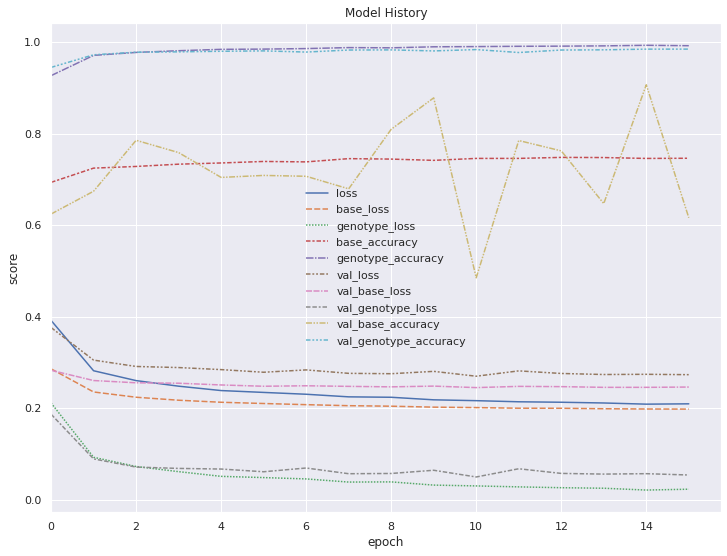

In [14]:
from matplotlib import rcParams, pyplot as plt
import dataframe_image as dfi
import seaborn as sns
import pandas as pd
# figure size in inches
rcParams['figure.figsize'] = 12,9
rcParams["legend.framealpha"] = 0.0

sns.set_theme()
sns.set(font_scale=1.0)  # crazy big
snsplot = sns.lineplot(data=pd.DataFrame(deepvcf.model.history.history))
snsplot.set(xlabel='epoch', ylabel='score', title='Model History', xlim=0)
snsplot.figure.savefig('example_files/images/giab-model-history.png')

# Use Model to generate a Variant Format File (VCF)

In [61]:
%%time
predicted_vcf_test = deepvcf.create_vcf(
    reference_file=ref_test,
    alignment_file=bam_test,
    save_pileup_to_destination='./example_files/human/chr22/giab-test-5.pileup.npy',
    use_saved_pileup='./example_files/human/chr22/giab-test-5.pileup.npy',  # Ignore the error, this will fail the first time if it doesn't exist
    # overwrite_variant_calls=True,
    mimimum_alignment_coverage=.5,
    minimum_coverage=20,
    heterozygous_threshold=.26,
    minimum_variant_radius=15,
    output_folder='./example_files/human/chr22/',  # save as an actual .vcf file
    output_prefix='test' 
)

=== Using Input Pileup ===
=== Overwriting Variant Calls === 
=== Pilup Complete ===
=== Tensors Complete ===
ambygous base catches: 0
bed catches: 0
size catches 0
fp total 47341
total 47341
CPU times: user 4min 4s, sys: 6.27 s, total: 4min 11s
Wall time: 4min 8s


# Valitdation Plots

In [36]:
dvcf_metrics = deepvcf.validation(
    predicted_vcf=pd.read_vcf('./example_files/human/chr22/test.deepvcf.vcf'),
    real_vcf=vcf_test,
)
dvcf = pd.DataFrame(dvcf_metrics).rename(columns={'hom_alt':'DeepVCf_hom_alt', 'het':'DeepVCF_het'})
dvcf

,DeepVCf_hom_alt,DeepVCF_het
Sensitivity,0.971285,0.908741
PPV,0.707775,0.700577
Accuracy,0.873678,0.738300
F1,0.818852,0.791196


In [1]:
(0.8188523660021939 + 0.7911962676733502) / 2

0.805024316837772

In [37]:
samvcf = pd.read_vcf('./example_files/human/chr22/chr22-filtered.bcftools.vcf')
print(samvcf.shape)
samvcf.head()

(914625, 10)


,CHROM,POS,ID,REF,ALT,QUAL,FILTER,INFO,FORMAT,NA12878
0,chr22,18924791,.,G,T,17.5439,LowQual,DP=23;VDB=0.18;SGB=-0.453602;RPB=0.738095;MQB=...,GT:PL:AD,"{'GT': '0/1', 'PL': '51,0,152', 'AD': '21,2'}"
1,chr22,18924875,.,G,A,21.3224,LowQual,DP=25;VDB=0.178985;SGB=-0.590765;RPB=0.999423;...,GT:PL:AD,"{'GT': '0/1', 'PL': '55,0,202', 'AD': '20,4'}"
2,chr22,18924934,.,C,A,25.5684,LowQual,DP=24;VDB=0.0751808;SGB=-0.556411;RPB=0.695586...,GT:PL:AD,"{'GT': '0/1', 'PL': '59,0,156', 'AD': '20,3'}"
3,chr22,18924979,.,A,G,8.16368,LowQual,DP=26;VDB=0.18;SGB=-0.453602;RPB=0.479167;MQB=...,GT:PL:AD,"{'GT': '0/1', 'PL': '42,0,253', 'AD': '24,2'}"
4,chr22,18925066,.,A,T,9.38819,LowQual,DP=26;VDB=0.045681;SGB=-0.511536;RPB=0.949775;...,GT:PL:AD,"{'GT': '0/1', 'PL': '43,0,227', 'AD': '23,3'}"


In [38]:
bcf_metrics = deepvcf.validation(
    predicted_vcf=samvcf,
    real_vcf=vcf_test,
)
bcf = pd.DataFrame(bcf_metrics).rename(columns={'hom_alt':'BCFtools_hom_alt', 'het':'BCFtools_het'})
bcf

,BCFtools_hom_alt,BCFtools_het
Sensitivity,0.083543,0.974025
PPV,0.998927,0.026114
Accuracy,0.720906,0.028905
F1,0.154190,0.050864


In [42]:
pd.concat([dvcf, bcf], axis=1).to_csv('giab-metrics.csv')# .style.background_gradient()

In [43]:
pwd

'/home/tmsincomb/Dropbox/git/DeepVCF/jupyter_nb'